# TM10007 Assignment template

In [0]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/sirivandermeijden/TM10007_PROJECT_SvdMeijden_MMolenaar     

 ##Taakverdeling eindopdracht:


---



1.   **Datapreperatie**


* *Verwijderen duplicaten kolommen (als aanwezig)*   DONE 
*  *Nulwaarden verwijderen* (Siri)        DONE
* *Trainingset/validatieset* (Mitch)       DONE
* Test for outliers (Mitch)  DONE
*  *Scaling features (Mitch)*   DONE
* PCA? (Siri)
* Feature selection (Siri)


2.   **Random Forest**
* Bagging/bootstrap aggregating 
* Hyperparameter tuning
* Ensembling 
3. **Support Vector Machine**
* Kernel
* Hyperparameter tuning 
4. **Multilayer neural network** 
* Activation and loss function
5. **Convolutional NN/Recurrent NN** 
(Ik weet niet zeker of we deze ook moeten toepassen) 


Checklist punten verslag / punten om overna te denken /overwegingen
1. Datapreparatie
- de data is numeriek (geen categorical data).
- De samples met de meest missende feature waardes: HN1106 (16 missing values), HN1600 (14 missing values), HN1760 (17 missing values). De rest van de data heeft 0, 3 of 7 features die 0 zijn. 
- De features met de meest missende sample waardes: tff_GLRLM_GrayLevelVariance (54 missing features), tff_GLSZM_GrayLevelVariance (54 missing features), tf_GLSZM_ZoneVariane (53), Tf_NGTDM_Busyness (54),  Tf_NGTDM_complexity (54),  Tf_NGTDM_contrast (54),  Tf_NGTDM_Strength (54). Veel missende waardes komen voor onder verschillende features. De andere features hebbben 0, 3 of 5 missende waarden.
- Er zijn weinig outliers (Zscore>3). 

Keuze: Omdat we relatief weinig samples hebben (113) is het niet handig om de samples weg te halen. Het lijkt mij handig om de features die veel samples missen te verwijderen. Verder is het onduidelijk of we zomaar alle nullen kunnen imputeren. Sommige features kunnen bijvoorbeeld echt de waarde 0 hebben (misschien moeten we dit zien als discussiepunt). We hoeven scaling niet aan te passen omdat we weinig outliers hebben. 

- We nemen aan dat basic classifiers (KNN, linear, quadratic etc.) te simpel zijn om te gebruiken (toch?). Wat kan het doen van feature selection hierover zeggen?
Als we toch basic classifiers gebruiken, moeten we hier voorafgaand PCA op toepassen?

28 maart: (Siri)
* Imputing: KNN classifier om missende data te imputeren voor scaling.

* Scaling: Standaard scaling toepassen om data normaal verdeeld rondom 0 te krijgen, nodig voor bepaalde classifiers (SVM, NN etc.), scaling wordt ook toegepast op test en validatie set. 





In [0]:
######## Import packages and models ##########################################

# Import general packages
import pandas as pd
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets as ds
import seaborn
from sklearn import model_selection

# import classifiers
from sklearn import model_selection
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

# import models
models = [
    ('NB', GaussianNB()),
    ('LDA', LinearDiscriminantAnalysis()),
    ('QDA', QuadraticDiscriminantAnalysis()),
    ('LR', LogisticRegression()),
    ('SGD', SGDClassifier()),
    ('DT', DecisionTreeClassifier()),
    ('KNN', KNeighborsClassifier()),   #hieronder verdere modellen toevoegen
]

# Import datapreprocessing
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn import preprocessing
from sklearn import feature_selection 

# Import split data in train and test set
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score # allows one scoring metric
from sklearn.model_selection import cross_validate # allows us to use multiple scoring metrics

# Import metrics
from sklearn import metrics

In [0]:
# Data loading functions. 
from hn.load_data import load_data
data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')
data.info
# Find labels assigned for tumor classification 
def unique(list1): 
    x = np.array(list1) 
    print(np.unique(x)) 

print("The unique labels assigned to each patient for tumor classification are ") 
unique(data['label'])

########################## Data preperation ##########################
# Map T12 and T34 to 0 and 1 respectively
mapping = {'T12': 0, 'T34': 1}
data=data.replace({'label': mapping})
# Select data with label
y= data['label']
# select data without labels
X = data.drop(['label'], axis=1)
# delete duplicated columns if available
data = data.loc[:,~data.columns.duplicated()] 

# Splitting data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # split train and test so that we don't touch test set.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1) # split train in validation and train set

# Remove features with >53 missing values.
X_train = (X_train.drop(['tf_GLRLM_GrayLevelVariance', 'tf_GLSZM_GrayLevelVariance', 'tf_GLSZM_ZoneVariance', 'tf_NGTDM_Busyness', 'tf_NGTDM_Complexity', 'tf_NGTDM_Contrast', 'tf_NGTDM_Strength'], axis=1))
X_val = (X_val.drop(['tf_GLRLM_GrayLevelVariance', 'tf_GLSZM_GrayLevelVariance', 'tf_GLSZM_ZoneVariance', 'tf_NGTDM_Busyness', 'tf_NGTDM_Complexity', 'tf_NGTDM_Contrast', 'tf_NGTDM_Strength'], axis=1))
X_test = (X_test.drop(['tf_GLRLM_GrayLevelVariance', 'tf_GLSZM_GrayLevelVariance', 'tf_GLSZM_ZoneVariance', 'tf_NGTDM_Busyness', 'tf_NGTDM_Complexity', 'tf_NGTDM_Contrast', 'tf_NGTDM_Strength'], axis=1))


# Impute missing data using KNN
X_train = X_train.replace(0, np.nan)

imp = KNNImputer(n_neighbors=2, weights="uniform")     #imp = SimpleImputer(missing_values=np.nan, strategy='mean') # impute NaN values with mean values
X_train_imp=pd.DataFrame(imp.fit_transform(X_train))
X_train_imp.columns=X_train.columns
X_train_imp.index=X_train.index

# scale both the training and test set, a standard scaler is used 
scaler = preprocessing.StandardScaler()
scaler.fit(X_train_imp)

X_train= scaler.transform(X_train_imp)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)



The number of samples: 113
The number of columns: 160
The unique labels assigned to each patient for tumor classification are 
['T12' 'T34']


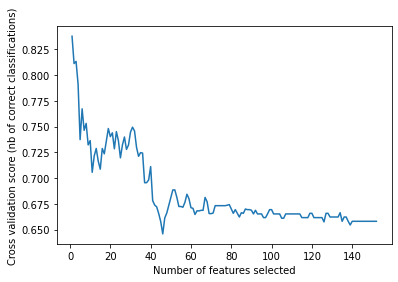

In [0]:
##########################Support Vector Machine##########################################

# Use recursive feature elimination (RFE)

# Create the RFE object and compute a cross-validated score.
svc = svm.SVC(kernel="linear")

# classifications using 5-fold stratified cross validation 
rfecv = feature_selection.RFECV(
    estimator=svc, step=1, 
    cv=model_selection.StratifiedKFold(5),
    scoring='roc_auc')
rfecv.fit(X_train, y_train)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()


In [0]:
## hieroner moet nog verder getest worden/ aan
##########################Comparing models: simple classifiers ###########################


# Hieronder toepassen van de verschillende modellen op de trainingsdata. Vervolgens berekenen metrics op validatie set. 
# Bereking metrics op testset is nog niet gebeurt. Hiervoor moet nog optimalisatie van parameters plaatsvinden (hoeveel splitsingen zijn nodig etc.)
dic= {}
scoring = ['roc_auc', 'accuracy', 'f1_macro', 'precision_macro', 'recall_macro']
for name, model in models:
        clf = model
        clf.fit(X_train, y_train)
        accuracy = clf.score(X_val, y_val)        # accuracy tested on validation data without cross validation
        #accuracy_CV = cross_val_score(clf, X, y, cv=5)
        for metric in scoring:                      # cross validation
            accuracy_CV = cross_validate(clf, X_val, y_val, cv=5, scoring=metric, return_train_score=False) # cv can also return train score but we set it to false
            test_score = accuracy_CV["test_score"]
            #dic = {name: test_score}
            dic[name, metric]=pd.DataFrame({'mean_score': {0:test_score.mean()}, 'std_score': {0:test_score.std()*2}})
##########################Cross- validation###########################